In [1]:
from OFDM_Models import *
import pandas as pd
from keras.layers import Add, MaxPooling2D, Activation
from tensorflow.keras.layers import Input, Conv1D, Activation, BatchNormalization, Add, Dense,MaxPooling1D,Flatten,Dropout,MaxPooling2D
from tensorflow.keras.layers import Layer, Conv2D, Conv1D, Flatten, Dense, Reshape, Conv2DTranspose,Concatenate
from tensorflow import keras
from keras.regularizers import l2
import tensorflow_addons as tfa

2024-03-04 00:30:37.056674: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-04 00:30:37.124293: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-04 00:30:37.124333: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-04 00:30:37.125654: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-04 00:30:37.135964: I tensorflow/core/platform/cpu_feature_guar

In [3]:

model_RFF_512 =  tf.keras.models.load_model('RFF_512.h5', custom_objects={'ConvRFF': ConvRFF,'F1Score': tfa.metrics.F1Score})
TSRNN_512 = tf.keras.models.load_model('TRSN_512.h5', custom_objects={'F1Score': tfa.metrics.F1Score})


In [4]:
models_dict = {
               "TSRNN + RFF (512)":[model_RFF_512,512],
               "TSRNN (512)":[TSRNN_512 ,512],

               }

In [5]:
y_test = np.load("DATASETS/y_test.npy",allow_pickle=True)
X_test = pd.read_hdf("DATASETS/test_data.h5",key="test")

/tmp/ipykernel_16134/56220103.py:2: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  X_test = pd.read_hdf("DATASETS/test_data.h5",key="test")


In [6]:
test = X_test.copy()
X_test = X_test.drop(columns="snr")
X_test = np.array(X_test.apply(lambda x: np.array([np.imag(x), np.real(x)]).T, axis=1).tolist())

In [7]:
import pickle

with open('encoder.pkl', 'rb') as file:
    encoder = pickle.load(file)

In [8]:
results = {}
for key in list(models_dict.keys()):
    model = models_dict[key][0]
    y_pred = model.predict(X_test[:,:models_dict[key][1],:])
    y_pred = np.argmax(y_pred, axis=1)
    results[key] = y_pred

2024-03-04 00:31:20.389055: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-04 00:31:20.492210: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-04 00:31:20.610122: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


3340/3340 [==============================] - 13s 4ms/step


In [9]:
import warnings
warnings.filterwarnings('ignore')


In [10]:
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt

# Set Seaborn style and scale
sns.set_style("whitegrid")
sns.set(font_scale=1.5, rc={'text.usetex': False})

def calculate_metrics_and_snrs(grouped_data):
    """Calculate accuracies, F1 Scores, and SNRs from grouped data."""
    accuracies = []
    f1_scores = []
    snrs = []
    for name, group in grouped_data:
        y_true = group['label']
        y_pred = group['Pred']
        accuracy = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average='macro')  # Assuming multi-class classification
        accuracies.append(accuracy)
        f1_scores.append(f1)
        snrs.append(name)
    return snrs, accuracies, f1_scores

def sort_lists_by_dB(snrs, metrics):
    """Sort lists by dB values."""
    sorted_lists = sorted(zip(snrs, metrics), key=lambda x: int(x[0].replace("dB", "")))
    sorted_dB_list, sorted_metric_list = zip(*sorted_lists)
    return sorted_dB_list, sorted_metric_list




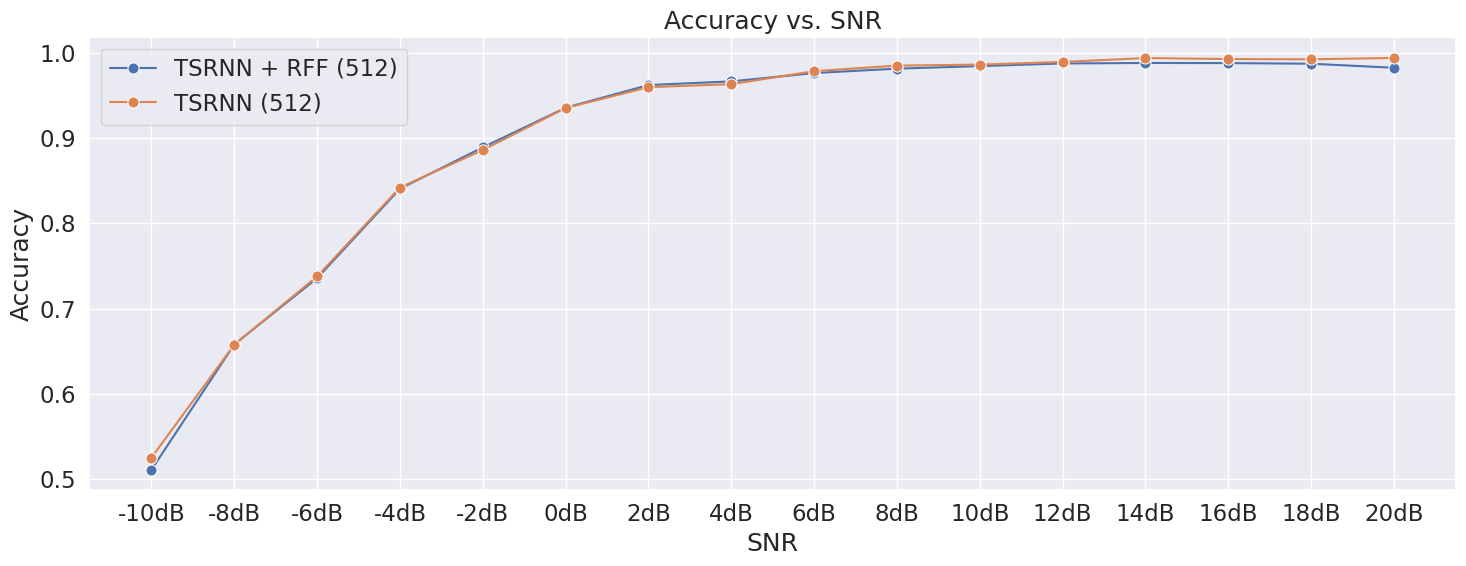

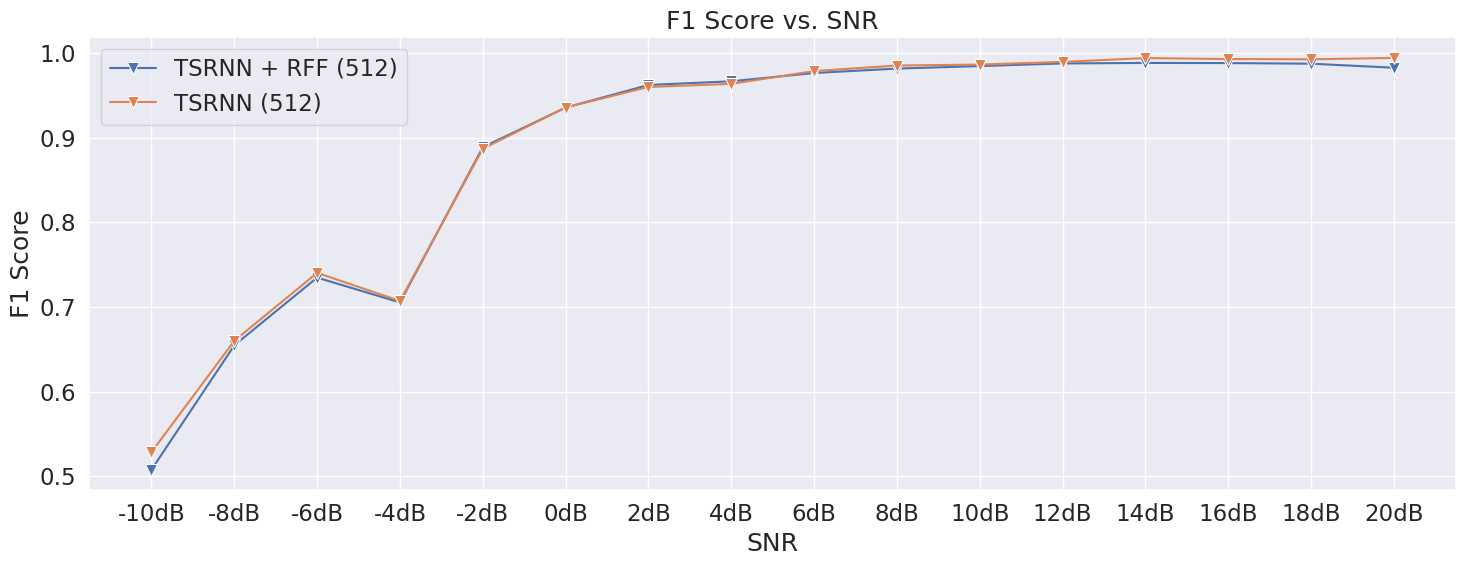

In [11]:
# Loop through each key-value pair in the dictionary for Accuracy
plt.figure(figsize=(15, 6))
for key, value in results.items():
    accuracy_df = test.copy()
    accuracy_df["Pred"] = value
    accuracy_df["label"] = y_test
    grouped = accuracy_df.groupby('snr')

    snrs, accuracies, f1s = calculate_metrics_and_snrs(grouped)
    sorted_dB_list_acc, sorted_accuracy_list = sort_lists_by_dB(snrs, accuracies)

    sns.lineplot(x=sorted_dB_list_acc, y=sorted_accuracy_list, marker="o", markersize=8, label=f"{key}")

# Set plot details for Accuracy
plt.xlabel('SNR')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. SNR')
plt.legend()
plt.tight_layout()
plt.show()

# Loop through each key-value pair in the dictionary for F1 Score
plt.figure(figsize=(15, 6))
for key, value in results.items():
    accuracy_df = test.copy()
    accuracy_df["Pred"] = value
    accuracy_df["label"] = y_test
    grouped = accuracy_df.groupby('snr')

    snrs, accuracies, f1s = calculate_metrics_and_snrs(grouped)
    sorted_dB_list_f1, sorted_f1_list = sort_lists_by_dB(snrs, f1s)

    sns.lineplot(x=sorted_dB_list_f1, y=sorted_f1_list, marker="v", markersize=8, label=f"{key}")

# Set plot details for F1 Score
plt.xlabel('SNR')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. SNR')
plt.legend()
plt.tight_layout()
plt.show()